# $CO_{2}$ Emission Prediction for Vehicles

<hr>

## Importing Libraries

In [218]:
import numpy as np
import pandas as pd

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

<hr>

## Loading Data

In [221]:
d1 = pd.read_excel("Fuel Consumption.xlsx", sheet_name="1995-1999")

In [222]:
d2 = pd.read_excel("Fuel Consumption.xlsx", sheet_name="2000-2014")

In [223]:
d3 = pd.read_excel("Fuel Consumption.xlsx", sheet_name="2015-2020")

In [224]:
data = pd.concat([d1, d2, d3])

data.reset_index(drop=True, inplace=True)

In [225]:
data.head()

,MODEL YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE (L),CYLINDERS,TRANSMISSION,FUEL TYPE,FUEL CONSUMPTION CITY (L/100),FUEL CONSUMPTION HWY (L/100),FUEL CONSUMPTION COMB (L/100),FUEL CONSUMPTION COMB (mpg),CO2 EMISSIONS (g/km)
0,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,1995,ACURA,INTEGRA GS-R,SUBCOMPACT,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,1995,ACURA,LEGEND,COMPACT,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,1995,ACURA,LEGEND COUPE,COMPACT,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [226]:
data.shape

(24097, 13)

* The data has 24097 rows and 13 columns.

<hr>

## Pre-processing

In [227]:
data["MAKE"].unique()

array(['ACURA', 'ALFA ROMEO', 'AUDI', 'BENTLEY', 'BMW', 'BUICK',
       'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'EAGLE', 'FERRARI',
       'FORD', 'GEO', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR', 'LEXUS',
       'LINCOLN', 'MERCURY', 'MAZDA', 'MERCEDES-BENZ', 'NISSAN',
       'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC', 'PORSCHE', 'ROLLS-ROYCE',
       'SAAB', 'SATURN', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN',
       'VOLVO', 'GMC', 'ISUZU', 'JEEP', 'LAND ROVER', 'DAEWOO', 'KIA',
       'MASERATI', 'MINI', 'MITSUBISHI', 'SMART', 'HUMMER',
       'ASTON MARTIN', 'LAMBORGHINI', 'BUGATTI', 'SCION', 'FIAT', 'RAM',
       'SRT', 'GENESIS', 'Acura', 'Alfa Romeo', 'Aston Martin', 'Audi',
       'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler',
       'Dodge', 'Ford', 'Genesis', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mitsubishi',
       'Nissan', 'Porsche',

* While most of the manufacturer names are in upper case, some of the manufacturer names are in title case.

* Let's convert the name of all manufacturers to upper case so that they are consistent.

In [228]:
data["MAKE"] = data["MAKE"].str.upper()

In [229]:
data["VEHICLE CLASS"].unique()

array(['SUBCOMPACT', 'COMPACT', 'TWO-SEATER', 'STATION WAGON - SMALL',
       'MINICOMPACT', 'MID-SIZE', 'FULL-SIZE', 'STATION WAGON - MID-SIZE',
       'PICKUP TRUCK - STANDARD', 'PICKUP TRUCK - SMALL', 'VAN - CARGO',
       'VAN - PASSENGER', 'MINIVAN', 'SUV', 'SUV - STANDARD',
       'SPECIAL PURPOSE VEHICLE', 'SUV - SMALL', 'Compact', 'SUV: Small',
       'Two-seater', 'Mid-size', 'Minicompact', 'Subcompact',
       'Station wagon: Small', 'Full-size', 'SUV: Standard',
       'Pickup truck: Small', 'Pickup truck: Standard', 'Minivan',
       'Van: Passenger', 'Special purpose vehicle',
       'Station wagon: Mid-size'], dtype=object)

* Let's replace **':'** in vehicle class by **' -'** because **"SUV: Small"** is the same as **"SUV - SMALL"**.
<br><br>
* Also, most of the vehicle classes are in upper case while some of the vehicle classes are in title case.

* Let's convert all vehicle classes to upper case so that they are consistent.

In [230]:
data["VEHICLE CLASS"] = data["VEHICLE CLASS"].str.replace(":", " -").str.upper()

<hr>

## Correlation between Continuous variables

In [231]:
# Data with only continuous variables
data_num_columns = data.select_dtypes(exclude=[object]).drop("MODEL YEAR", axis=1)

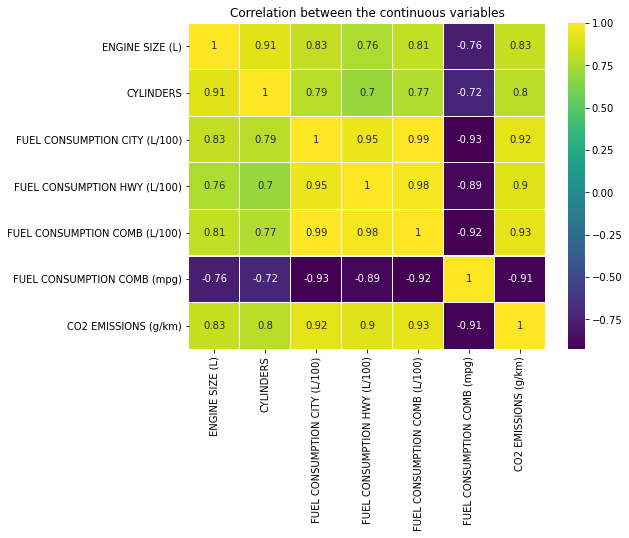

In [232]:
plt.figure(figsize=(8,6))
plt.title("Correlation between the continuous variables")

sns.heatmap(data_num_columns.corr(), annot=True,
            cmap="viridis", linecolor="white", linewidths=0.1);

* We can observe that all variables have a strong positive correlation with $CO_{2}$ EMISSIONS (g/km) while FUEL CONSUMPTION COMB (mpg) has a strong negative correlation with $CO_{2}$ EMISSIONS (g/km).<br><br>

* Thus, we can include all the continuous variables to predict the $CO_{2}$ emission of vehicles.

<hr>

## ANOVA test on Categorical variables

* We perform ANOVA test to check the impact of categorical variables on the target variable which is a continuous variable in our case.
<br><br>

* The null hypothesis of the test assumes that the average of different groups in a categorical variable is similar.<br>In order words, the difference between the average of different groups in a categorical variable is not significant.
<br><br>

* The alternate hypothesis states that the difference between the average of different groups in a categorical variable is significant.
<br><br>

* The value of F-score and p-value determines which of tho two hypothesis is true.
* If the null hypothesis is true, the concerned categorical variable won't be of much help in predicting the target variable.
* If the alternate hypothesis is true, the concerned categorical variable will be helpful in predicting the target variable.

### ANOVA test for MAKE

In [233]:
from scipy import stats

In [234]:
make_grp = data.groupby("MAKE")

make_emission = []

for make in make_grp.indices.keys():
    make_emission.append(make_grp.get_group(make)["CO2 EMISSIONS (g/km)"])

In [235]:
f_score_make, p_val_make = stats.f_oneway(*make_emission)

print(f"F-score: {f_score_make}\tp-value: {p_val_make}")

F-score: 281.4380856410214	p-value: 0.0


* The **F-score** and **p-value** confirms that the difference between average $CO_{2}$ emissions of each car manufacturer is significant.<br>Thus, we include the feature to build our model for predicting the $CO_{2}$ emission of vehicles.

### ANOVA test for VEHICLE CLASS

In [236]:
vehicle_class_grp = data.groupby("VEHICLE CLASS")

cls_emission = []

for cls in vehicle_class_grp.indices.keys():
    cls_emission.append(vehicle_class_grp.get_group(cls)["CO2 EMISSIONS (g/km)"])

In [237]:
f_score_cls, p_val_cls = stats.f_oneway(*cls_emission)

print(f"F-score: {f_score_cls}\tp-value: {p_val_cls}")

F-score: 816.088784138182	p-value: 0.0


* The **F-score** and **p-value** confirms that the difference between average $CO_{2}$ emissions of each vehicle class is significant.<br>Thus, we include the feature to build our model for predicting the $CO_{2}$ emission of vehicles.

### ANOVA test for TRANSMISSION

In [238]:
trans_grp = data.groupby("TRANSMISSION")

trans_emission = []

for trans in trans_grp.indices.keys():
    trans_emission.append(trans_grp.get_group(trans)["CO2 EMISSIONS (g/km)"])

In [239]:
f_score_trans, p_val_trans = stats.f_oneway(*trans_emission)

print(f"F-score: {f_score_trans}\tp-value: {p_val_trans}")

F-score: 154.64665826893435	p-value: 0.0


* The **F-score** and **p-value** confirms that the difference between average $CO_{2}$ emissions of each transmission is significant.<br>Thus, we include the feature to build our model for predicting the $CO_{2}$ emission of vehicles.

### ANOVA test for FUEL TYPE

In [240]:
fuel_grp = data.groupby("FUEL TYPE")

fuel_emission = []

for f in fuel_grp.indices.keys():
    fuel_emission.append(fuel_grp.get_group(f)["CO2 EMISSIONS (g/km)"])

In [241]:
f_score_fuel, p_val_fuel = stats.f_oneway(*fuel_emission)

print(f"F-score: {f_score_fuel}\tp-value: {p_val_fuel}")

F-score: 138.30874429455258	p-value: 4.557773247644173e-117


* The **F-score** and **p-value** confirms that the difference between average $CO_{2}$ emissions of each fuel type is significant.<br>Thus, we include the feature to build our model for predicting the $CO_{2}$ emission of vehicles.

<hr>

## One-Hot encoding on Categorical variables

* Let's convert all the categorical variables in the data into a numerical variables by One-Hot encoding.

In [242]:
make_dummy = pd.get_dummies(data["MAKE"], prefix="MAKE")

data = data.join(make_dummy)

In [243]:
vehicle_cls_dummy = pd.get_dummies(data["VEHICLE CLASS"], prefix="VEHICLE_CLASS")

data = data.join(vehicle_cls_dummy)

In [244]:
trans_dummy = pd.get_dummies(data["TRANSMISSION"], prefix="TRANSMISSION")

data = data.join(trans_dummy)

In [245]:
fuel_type_dummy = pd.get_dummies(data["FUEL TYPE"], prefix="FUEL_TYPE")

data = data.join(fuel_type_dummy)

* Now, let's drop the unwanted columns from the data.

In [246]:
columns_to_drop = ["MODEL YEAR", "MAKE", "MODEL", "VEHICLE CLASS", "TRANSMISSION", "FUEL TYPE"]

data.drop(columns_to_drop, axis=1, inplace=True)

In [247]:
data.head()

,ENGINE SIZE (L),CYLINDERS,FUEL CONSUMPTION CITY (L/100),FUEL CONSUMPTION HWY (L/100),FUEL CONSUMPTION COMB (L/100),FUEL CONSUMPTION COMB (mpg),CO2 EMISSIONS (g/km),MAKE_ACURA,MAKE_ALFA ROMEO,MAKE_ASTON MARTIN,...,TRANSMISSION_AV8,TRANSMISSION_M4,TRANSMISSION_M5,TRANSMISSION_M6,TRANSMISSION_M7,FUEL_TYPE_D,FUEL_TYPE_E,FUEL_TYPE_N,FUEL_TYPE_X,FUEL_TYPE_Z
0,1.8,4,10.2,7.0,8.8,32,202,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.8,4,9.6,7.0,8.4,34,193,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.8,4,9.4,7.0,8.3,34,191,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3.2,6,12.6,8.9,10.9,26,251,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.2,6,13.0,9.3,11.3,25,260,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [248]:
data.shape

(24097, 113)

* The data now has 24097 rows and 113 columns.

<hr>

## Training, Validation and Testing data

In [249]:
from sklearn.model_selection import train_test_split

In [250]:
X = data.drop("CO2 EMISSIONS (g/km)", axis=1)
y = data["CO2 EMISSIONS (g/km)"]

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [252]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [253]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (14458, 112) (14458,)
Validation data shape: (4820, 112) (4820,)
Test data shape: (4819, 112) (4819,)


<hr>

## Scaling data for a few algorithms

In [254]:
from sklearn.preprocessing import MinMaxScaler

In [255]:
scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler()

In [256]:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

<hr>

## Linear Regression

In [257]:
from sklearn.linear_model import LinearRegression

In [258]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

**Model performance on Validation set and Test set**

In [259]:
print("Validation score:", round(lr.score(X_val, y_val), 4))
print()
print("Test score:", round(lr.score(X_test, y_test), 4))

Validation score: 0.9951

Test score: 0.9951


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [260]:
lr_val_pred = lr.predict(X_val)
lr_test_pred = lr.predict(X_test)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, lr_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, lr_test_pred)), 3))

RMSE on Validation set: 4.134

RMSE on Test set: 4.226


* Thus on average, the difference between the actual values and predicted values on the Validation set is **4.134**.

* The average difference between the actual values and predicted values on the Test set is **4.226**.

**Feature Importance**

In [261]:
lr_feat_imp = sorted(zip(X.columns, lr.coef_), key=lambda x: abs(x[1]), reverse=True)

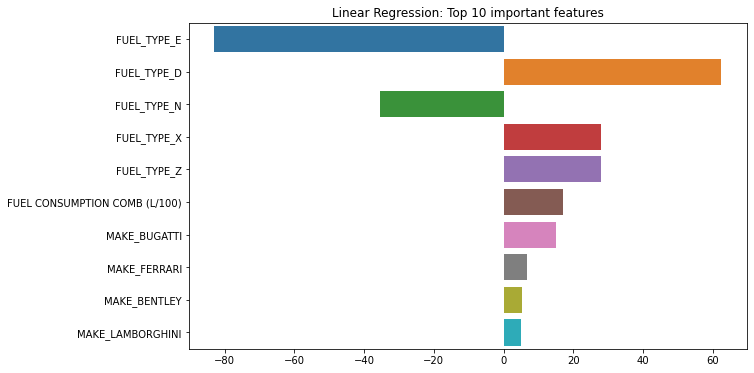

In [262]:
plt.figure(figsize=(10,6))
plt.title("Linear Regression: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], lr_feat_imp[:10])),
            y=list(map(lambda x: x[0], lr_feat_imp[:10])),
            orient="h");

* It is really interesting to see that the different FUEL TYPES have the most influence in predicting the amount of $CO_{2}$ emission by the vehicles.

<hr>

## Ridge Regression

In [263]:
from sklearn.linear_model import Ridge

In [264]:
# # Code to perform hyperparameter tuning using GridSearchCV

# rr = Ridge()
# rr_params = {"alpha": np.logspace(-4, 4, 9)}

# rr_cv = GridSearchCV(rr, rr_params)
# rr_cv.fit(X_train_scaled, y_train)

# print(rr_cv.best_params_)                      # prints the best parameter set of the model (alpha=0.0001)

# rr_best = rr_cv.best_estimator_
# rr_best.fit(X_train_scaled, y_train)

# print(rr_best.score(X_val_scaled, y_val))
# print(rr_best.score(X_test_scaled, y_test))

In [265]:
rr = Ridge(alpha=0.0001)

rr.fit(X_train_scaled, y_train)

Ridge(alpha=0.0001)

**Model performance on Validation set and Test set**

In [266]:
print("Validation score:", round(rr.score(X_val_scaled, y_val), 4))
print()
print("Test score:", round(rr.score(X_test_scaled, y_test), 4))

Validation score: 0.9951

Test score: 0.9951


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [267]:
rr_val_pred = rr.predict(X_val_scaled)
rr_test_pred = rr.predict(X_test_scaled)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, rr_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, rr_test_pred)), 3))

RMSE on Validation set: 4.134

RMSE on Test set: 4.226


* Thus on average, the difference between the actual values and predicted values on the Validation set is **4.134**.

* The average difference between the actual values and predicted values on the Test set is **4.226**.

**Feature Importance**

In [268]:
rr_feat_imp = sorted(zip(X.columns, rr.coef_), key=lambda x: abs(x[1]), reverse=True)

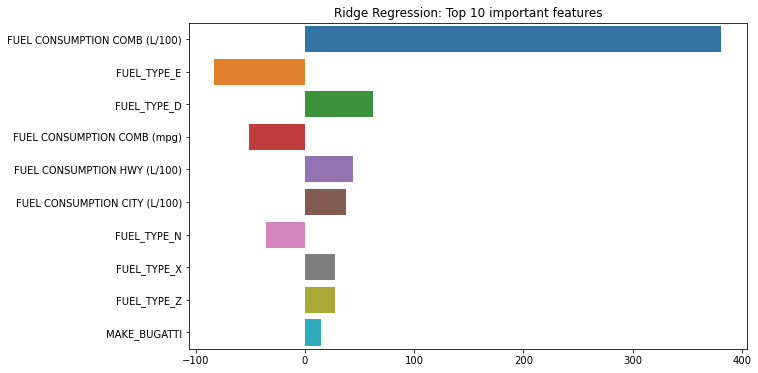

In [269]:
plt.figure(figsize=(10,6))
plt.title("Ridge Regression: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], rr_feat_imp[:10])),
            y=list(map(lambda x: x[0], rr_feat_imp[:10])),
            orient="h");

* FUEL CONSUMPTION COMB (L/100) has the most influence in predicting the $CO_{2}$ emission.

<hr>

## Lasso Regression

In [270]:
from sklearn.linear_model import Lasso

In [271]:
# # Code to perform hyperparameter tuning using GridSearchCV

# las = Lasso()
# las_params = {"alpha": np.logspace(-4, 4, 9)}

# las_cv = GridSearchCV(las, las_params)
# las_cv.fit(X_train_scaled, y_train)

# print(las_cv.best_params_)               # prints the best parameter set of the model (alpha=0.001)

# las_best = las_cv.best_estimator_
# las_best.fit(X_train_scaled, y_train)

# print(las_best.score(X_val_scaled, y_val))
# print(las_best.score(X_test_scaled, y_test))

In [272]:
las = Lasso(alpha=0.001)

las.fit(X_train_scaled, y_train)

c:\users\dell\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13431.444700492779, tolerance: 5123.884597399365
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

**Model performance on Validation set and Test set**

In [273]:
print("Validation score:", round(las.score(X_val_scaled, y_val), 4))
print()
print("Test score:", round(las.score(X_test_scaled, y_test), 4))

Validation score: 0.9949

Test score: 0.9948


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [274]:
las_val_pred = las.predict(X_val_scaled)
las_test_pred = las.predict(X_test_scaled)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, las_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, las_test_pred)), 3))

RMSE on Validation set: 4.205

RMSE on Test set: 4.348


* Thus on average, the difference between the actual values and predicted values on the Validation set is **4.205**.

* The average difference between the actual values and predicted values on the Test set is **4.348**.

**Feature Importance**

In [275]:
las_feat_imp = sorted(zip(X.columns, las.coef_), key=lambda x: abs(x[1]), reverse=True)

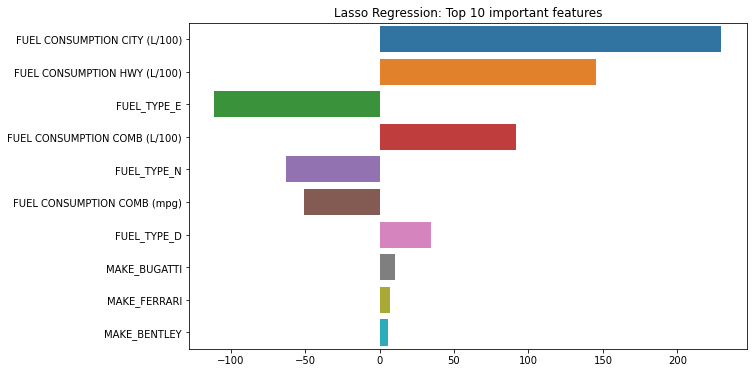

In [276]:
plt.figure(figsize=(10,6))
plt.title("Lasso Regression: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], las_feat_imp[:10])),
            y=list(map(lambda x: x[0], las_feat_imp[:10])),
            orient="h");

* FUEL CONSUMPTION CITY (L/100) and FUEL CONSUMPTION HWY (L/100) have the most influence.

<hr>

## KNN

In [277]:
from sklearn.neighbors import KNeighborsRegressor

In [278]:
# # Code to perform hyperparameter tuning using GridSearchCV

# knn = KNeighborsRegressor()
# knn_params = {"n_neighbors": [1, 5, 10, 20, 30, 50, 75, 100]}

# knn_cv = GridSearchCV(knn, knn_params)
# knn_cv.fit(X_train_scaled, y_train)

# print(knn_cv.best_params_)               # prints the best parameter set of the model (n_neighbors=1)

# knn_best = knn_cv.best_estimator_
# knn_best.fit(X_train_scaled, y_train)

# print(knn_best.score(X_val_scaled, y_val))
# print(knn_best.score(X_test_scaled, y_test))

In [279]:
knn = KNeighborsRegressor(n_neighbors=1)

knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=1)

**Model performance on Validation set and Test set**

In [280]:
print("Validation score:", round(knn.score(X_val_scaled, y_val), 4))
print()
print("Test score:", round(knn.score(X_test_scaled, y_test), 4))

Validation score: 0.9792

Test score: 0.9775


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [281]:
knn_val_pred = knn.predict(X_val_scaled)
knn_test_pred = knn.predict(X_test_scaled)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, knn_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, knn_test_pred)), 3))

RMSE on Validation set: 8.521

RMSE on Test set: 9.025


* Thus on average, the difference between the actual values and predicted values on the Validation set is **8.521**.

* The average difference between the actual values and predicted values on the Test set is **9.025**.

**Feature Importance**

* There doesn't exist an attribute for KNN object to view the importance of features.

## Decision Tree

In [282]:
from sklearn.tree import DecisionTreeRegressor

In [283]:
# # Code to perform hyperparameter tuning using GridSearchCV

# dt = DecisionTreeRegressor(random_state=101)
# dt_params = {"max_depth": [3, 5, 10, 15, 20, 30, 40, 50, 70, 100, None]}

# dt_cv = GridSearchCV(dt, dt_params)
# dt_cv.fit(X_train, y_train)

# print(dt_cv.best_params_)             # prints the best parameter set of the model (max_depth=15)

# dt_best = dt_cv.best_estimator_
# dt_best.fit(X_train, y_train)

# print(dt_best.score(X_val, y_val))
# print(dt_best.score(X_test, y_test))

In [284]:
dt = DecisionTreeRegressor(max_depth=15, random_state=101)

dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, random_state=101)

**Model performance on Validation set and Test set**

In [285]:
print("Validation score:", round(dt.score(X_val, y_val), 4))
print()
print("Test score:", round(dt.score(X_test, y_test), 4))

Validation score: 0.9987

Test score: 0.9981


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [286]:
dt_val_pred = dt.predict(X_val)
dt_test_pred = dt.predict(X_test)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, dt_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, dt_test_pred)), 3))

RMSE on Validation set: 2.114

RMSE on Test set: 2.659


* Thus on average, the difference between the actual values and predicted values on the Validation set is **2.114**.

* The average difference between the actual values and predicted values on the Test set is **2.659**.

**Feature Importance**

In [287]:
dt_feat_imp = sorted(zip(X.columns, dt.feature_importances_), key=lambda x: abs(x[1]), reverse=True)

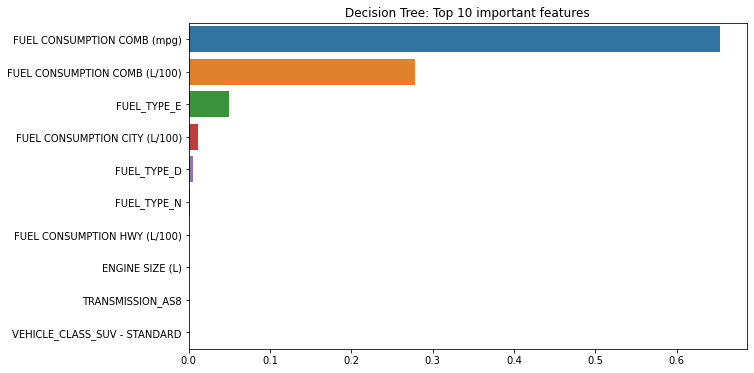

In [288]:
plt.figure(figsize=(10,6))
plt.title("Decision Tree: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], dt_feat_imp[:10])),
            y=list(map(lambda x: x[0], dt_feat_imp[:10])),
            orient="h");

* FUEL CONSUMPTION COMB (mpg) and FUEL CONSUMPTION COMB (L/100) have the most influence in predicting the $CO_{2}$ emission.

<hr>

## Random Forest

In [289]:
from sklearn.ensemble import RandomForestRegressor

In [290]:
# # Code to perform hyperparameter tuning using GridSearchCV


# rf = RandomForestRegressor(random_state=101)
# rf_params = {"n_estimators": [50, 100, 150, 200, 250, 300, 400, 500],
#              "max_depth": [3, 5, 10, None]}

# rf_cv = GridSearchCV(rf, rf_params)
# rf_cv.fit(X_train, y_train)

# print(rf_cv.best_params_)                # {'max_depth': None, 'n_estimators': 500}

# rf_best = rf_cv.best_estimator_
# rf_best.fit(X_train, y_train)

# print(rf_best.score(X_val, y_val))
# print(rf_best.score(X_test, y_test))

In [291]:
rf = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=101)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=101)

**Model performance on Validation set and Test set**

In [292]:
print("Validation score:", round(rf.score(X_val, y_val), 4))
print()
print("Test score:", round(rf.score(X_test, y_test), 4))

Validation score: 0.9989

Test score: 0.9983


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [293]:
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, rf_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, rf_test_pred)), 3))

RMSE on Validation set: 1.985

RMSE on Test set: 2.449


* Thus on average, the difference between the actual values and predicted values on the Validation set is **1.985**.

* The average difference between the actual values and predicted values on the Test set is **2.449**.

**Feature Importance**

In [294]:
rf_feat_imp = sorted(zip(X.columns, rf.feature_importances_), key=lambda x: abs(x[1]), reverse=True)

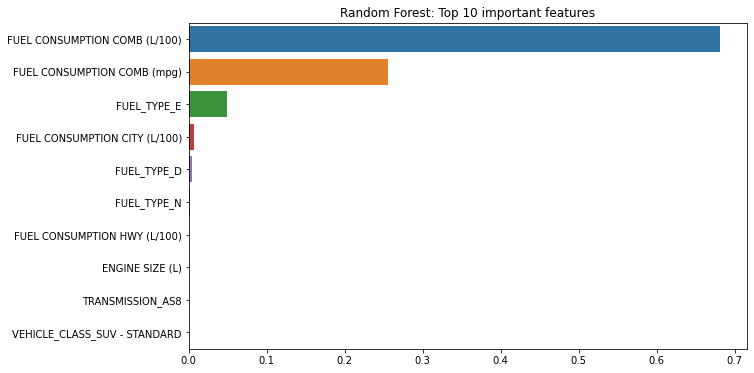

In [295]:
plt.figure(figsize=(10,6))
plt.title("Random Forest: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], rf_feat_imp[:10])),
            y=list(map(lambda x: x[0], rf_feat_imp[:10])),
            orient="h");

<hr>

## Gradient Boosted Trees

In [296]:
from sklearn.ensemble import GradientBoostingRegressor

In [297]:
# # Code to perform hyperparameter tuning using GridSearchCV

# gb = GradientBoostingRegressor(random_state=101)
# gb_params = {"n_estimators": [50, 100, 200, 300, 400, 500],
#              "max_depth": [3, 5, 10, None],
#              "learning_rate": [0.001, 0.01, 0.1, 1]}

# gb_cv = GridSearchCV(gb, gb_params)
# gb_cv.fit(X_train, y_train)

# print(gb_cv.best_params_)            # {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

# gb_best = gb_cv.best_estimator_
# gb_best.fit(X_train, y_train)

# print(gb_best.score(X_val, y_val))
# print(gb_best.score(X_test, y_test))

In [298]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=101)
gb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=101)

**Model performance on Validation set and Test set**

In [299]:
print("Validation score:", round(gb.score(X_val, y_val), 4))
print()
print("Test score:", round(gb.score(X_test, y_test), 4))

Validation score: 0.9989

Test score: 0.9986


**Root Mean Squared Error (RMSE) of the model on the Validation set and Test set.**

In [300]:
gb_val_pred = gb.predict(X_val)
gb_test_pred = gb.predict(X_test)

print("RMSE on Validation set:", round(np.sqrt(mean_squared_error(y_val, gb_val_pred)), 3))
print()
print("RMSE on Test set:", round(np.sqrt(mean_squared_error(y_test, gb_test_pred)), 3))

RMSE on Validation set: 1.934

RMSE on Test set: 2.237


* Thus on average, the difference between the actual values and predicted values on the Validation set is **1.934**.

* The average difference between the actual values and predicted values on the Test set is **2.237**.

**Feature Importance**

In [301]:
gb_feat_imp = sorted(zip(X.columns, gb.feature_importances_), key=lambda x: abs(x[1]), reverse=True)

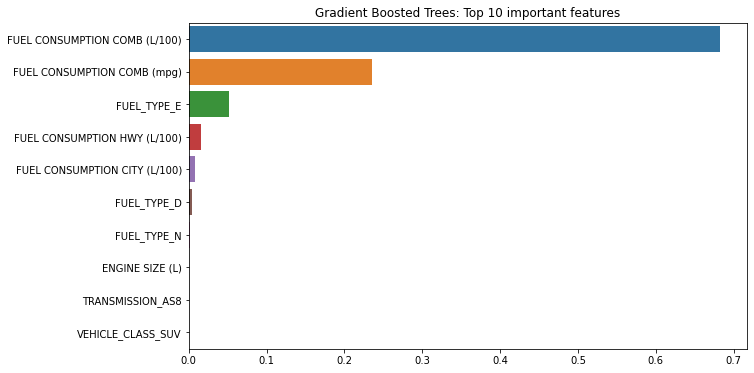

In [302]:
plt.figure(figsize=(10,6))
plt.title("Gradient Boosted Trees: Top 10 important features")

sns.barplot(x=list(map(lambda x: x[1], gb_feat_imp[:10])),
            y=list(map(lambda x: x[0], gb_feat_imp[:10])),
            orient="h");

* FUEL CONSUMPTION COMB (L/100) and FUEL CONSUMPTION COMB (mpg) have the most influence in predicting the $CO_{2}$ emission.

<hr>

## Final Results

In [303]:
models = {"Linear Regression": lr, "Decision Tree": dt, "Random Forest": rf, "Gradient Boosted Trees": gb}

# Models which require scaled input
scaled_models = {"Ridge Regression": rr, "Lasso Regression": las, "K-Nearest Neighbors": knn}

In [304]:
cols = pd.MultiIndex.from_product([["Validation set", "Test set"], ["R2 Score", "RMSE"]])

model_results = pd.DataFrame(index=["Linear Regression", "Ridge Regression", "Lasso Regression",
                                    "K-Nearest Neighbors", "Decision Tree", "Random Forest",
                                   "Gradient Boosted Trees"],
                             columns=cols, dtype=np.float64)

In [305]:
for mod_name, mod_obj in models.items():
    model_results.loc[mod_name, ("Validation set", "R2 Score")] = mod_obj.score(X_val, y_val)
    model_results.loc[mod_name, ("Validation set", "RMSE")] = np.sqrt(mean_squared_error(y_val, mod_obj.predict(X_val)))
    
    model_results.loc[mod_name, ("Test set", "R2 Score")] = mod_obj.score(X_test, y_test)
    model_results.loc[mod_name, ("Test set", "RMSE")] = np.sqrt(mean_squared_error(y_test, mod_obj.predict(X_test)))

    
for mod_name, mod_obj in scaled_models.items():
    model_results.loc[mod_name, ("Validation set", "R2 Score")] = mod_obj.score(X_val_scaled, y_val)
    model_results.loc[mod_name, ("Validation set", "RMSE")] = np.sqrt(mean_squared_error(y_val, mod_obj.predict(X_val_scaled)))
    
    model_results.loc[mod_name, ("Test set", "R2 Score")] = mod_obj.score(X_test_scaled, y_test)
    model_results.loc[mod_name, ("Test set", "RMSE")] = np.sqrt(mean_squared_error(y_test, mod_obj.predict(X_test_scaled)))
    

In [306]:
model_results[[("Validation set", "R2 Score"),
               ("Test set", "R2 Score")]] = model_results[[("Validation set", "R2 Score"),
                                                           ("Test set", "R2 Score")]].round(4)

model_results[[("Validation set", "RMSE"),
               ("Test set", "RMSE")]] = model_results[[("Validation set", "RMSE"),
                                                           ("Test set", "RMSE")]].round(3)

model_results

Validation set        Test set       
                             R2 Score   RMSE R2 Score   RMSE
Linear Regression              0.9951  4.134   0.9951  4.226
Ridge Regression               0.9951  4.134   0.9951  4.226
Lasso Regression               0.9949  4.205   0.9948  4.348
K-Nearest Neighbors            0.9792  8.521   0.9775  9.025
Decision Tree                  0.9987  2.114   0.9981  2.659
Random Forest                  0.9989  1.985   0.9983  2.449
Gradient Boosted Trees         0.9989  1.934   0.9986  2.237

## Conclusion

**Gradient Boosted Trees**

* The model performs the best among all the other models with an accuracy of **99.89%** on the validation set and **99.86%** on the test set.<br>
* The Root Mean Squared Error of the model is the least among all the other models on both validation set as well as test set.
<br><br>

**Random Forest**

* The model's performance is almost similar to Gradient Boosted Trees with an accuracy of **99.89%** on the validation set and **99.83%** on the test set.<br>
* The Root Mean Squared Error of the model on the validation set is **1.985** and test set is **2.449**.
<br><br>

**K-Nearest Neighbors**

* The model performs the worst among all the other models with an accuracy of **97.92%** on the validation set and **97.75%** on the test set.<br>
* The Root Mean Squared Error of the model is the highest among all the other models on both validation set as well as test set.
<br><br>

<hr>